In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import plotly
pd.options.display.max_rows = 20

from hearthstone.enums import CardClass
from hearthstone import cardxml
db = cardxml.load()[0]
import matplotlib
matplotlib.style.use('ggplot')

In [3]:
def card_class(e):
    return db[e].card_class.name if e else float('NaN')

df = pd.read_csv('crash_brawl_final.csv',
                 names=['First player', 'Friendly player', 'Player1 Hero',
                        'Player2 Hero', 'Player1 Playstate', 'Player2 Playstate', 'Turn',
                        'FirstPlayer Pick', 'FirstPlayer Choice1', 'FirstPlayer Choice2',
                        'FirstPlayer Choice3', 'SecPlayer Pick', 'SecPlayer Choice1',
                        'SecPlayer Choice2', 'SecPlayer Choice3'],
                 converters={column: card_class for column in ['Player1 Hero',
                                                              'Player2 Hero',
                                                              'FirstPlayer Pick',
                                                              'FirstPlayer Choice1',
                                                              'FirstPlayer Choice2',
                                                              'FirstPlayer Choice3',
                                                              'SecPlayer Pick',
                                                              'SecPlayer Choice1',
                                                              'SecPlayer Choice2',
                                                              'SecPlayer Choice3']})

In [4]:
# Rearrange columns in terms of friendly and opposing player
from collections import OrderedDict

def remap_columns(row):
    friendly_idx = row['Friendly player']
    friendly_text = 'First' if friendly_idx == row['First player'] else 'Sec'
    other_idx = 2 if friendly_idx == 1 else 1
    other_text = 'First' if other_idx == row['First player'] else 'Sec'
    pick = row['%sPlayer Pick' % friendly_text]

    return pd.Series(OrderedDict([
                ['Is First', friendly_idx == row['First player']],
                ['Player Index', friendly_idx],
                ['Won', row['Player%d Playstate' % friendly_idx] == 'WON'],
                ['Turn', row['Turn']],
                ['Player Hero', row['Player%d Hero' % friendly_idx]],
                ['Other Hero', row['Player%d Hero' % other_idx]],
                ['Player Pick', pick],
                ['Player Choice1', row['%sPlayer Choice1' % friendly_text]],
                ['Player Choice2', row['%sPlayer Choice2' % friendly_text]],
                ['Player Choice3', row['%sPlayer Choice3' % friendly_text]],                
                ['Player Pick Idx', (1 if row['%sPlayer Choice1' % friendly_text] == pick
                                     else 2 if row['%sPlayer Choice2' % friendly_text] == pick
                                     else 3)],
                ['Other Pick', row['%sPlayer Pick' % other_text]],
            ]))
remapped = df.apply(remap_columns, axis=1)
remapped

choice_dummies = sum(pd.get_dummies(remapped['Player Choice%d' % (idx + 1)], prefix='Choice') for idx in range(3))
remapped.join(choice_dummies)
None # Hide output

In [338]:
# Dump things out so other people can use the nice version
remapped.to_csv('crash_brawl_final_remapped.csv')

In [6]:
pairs1 = remapped[['Won', 'Player Hero', 'Player Pick']].copy()
pairs1.columns = ['Won', 'Hero', 'Pick']
pairs2 = remapped[['Won', 'Other Hero', 'Other Pick']].copy()
pairs2['Won'] = ~pairs2['Won']
pairs2.columns = ['Won', 'Hero', 'Pick']
pairs = pd.concat([pairs1, pairs2])

def to_pct(dbl):
    return '%.1f%%' % (dbl * 100)

t = pd.crosstab(pairs['Won'], [pairs['Hero'], pairs['Pick']])

with_pop = pd.DataFrame((t[1:] / t.sum()).T[True]).join(
    pd.DataFrame(pairs.groupby(['Hero', 'Pick']).size() / len(pairs)))
with_pop.columns = ['Win Rate', 'Popularity']
with_pop['Win Rate'] = with_pop['Win Rate'].apply(to_pct)
with_pop['Popularity'] = with_pop['Popularity'].apply(to_pct)

with_pop = with_pop.sort_values(by='Win Rate', ascending=False)

from tabulate import tabulate
print(tabulate(with_pop.head(5), ['1st / 2nd Hero', 'Pick', 'Win Rate', 'Popularity'], tablefmt="pipe"))
print('\n')
print(tabulate(with_pop.tail(5), ['1st / 2nd Hero', 'Win Rate', 'Popularity'], tablefmt="pipe"))

print('\n')

with_pop = with_pop.sort_values(by='Popularity', ascending=False)

print(tabulate(with_pop.head(5), ['1st / 2nd Hero', 'Pick', 'Win Rate', 'Popularity'], tablefmt="pipe"))
print('\n')
print(tabulate(with_pop.tail(5), ['1st / 2nd Hero', 'Win Rate', 'Popularity'], tablefmt="pipe"))

| 1st / 2nd Hero         | Pick   | Win Rate   |
|:-----------------------|:-------|:-----------|
| ('PALADIN', 'WARRIOR') | 59.6%  | 1.3%       |
| ('MAGE', 'PALADIN')    | 57.8%  | 3.2%       |
| ('PALADIN', 'MAGE')    | 57.4%  | 2.9%       |
| ('MAGE', 'HUNTER')     | 56.6%  | 2.6%       |
| ('ROGUE', 'PALADIN')   | 56.3%  | 1.5%       |


| 1st / 2nd Hero         | Win Rate   | Popularity   |
|:-----------------------|:-----------|:-------------|
| ('WARRIOR', 'WARLOCK') | 42.1%      | 0.5%         |
| ('WARRIOR', 'HUNTER')  | 42.0%      | 1.1%         |
| ('PRIEST', 'DRUID')    | 41.9%      | 1.3%         |
| ('PRIEST', 'WARLOCK')  | 39.2%      | 0.8%         |
| ('HUNTER', 'PRIEST')   | 39.0%      | 0.7%         |


| 1st / 2nd Hero      | Pick   | Win Rate   |
|:--------------------|:-------|:-----------|
| ('MAGE', 'PALADIN') | 57.8%  | 3.2%       |
| ('PALADIN', 'MAGE') | 57.4%  | 2.9%       |
| ('MAGE', 'HUNTER')  | 56.6%  | 2.6%       |
| ('MAGE', 'DRUID')   | 55.4%  | 2.6% 

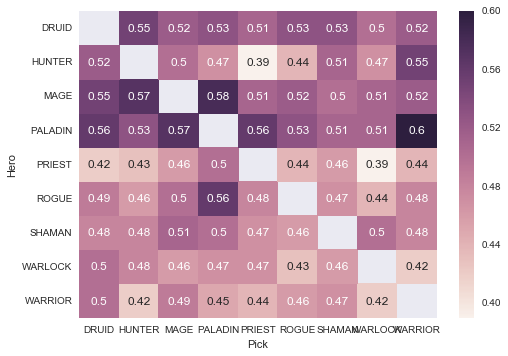

In [7]:
import seaborn as sns

pairs1 = remapped[['Won', 'Player Hero', 'Player Pick']].copy()
pairs1.columns = ['Won', 'Hero', 'Pick']
pairs2 = remapped[['Won', 'Other Hero', 'Other Pick']].copy()
pairs2['Won'] = ~pairs2['Won']
pairs2.columns = ['Won', 'Hero', 'Pick']
pairs = pd.concat([pairs1, pairs2])

t = pd.crosstab(pairs['Won'], [pairs['Hero'], pairs['Pick']])
p = (t[1:] / t.sum()).T.unstack(level=1).round(2)
sns.heatmap(p[True], annot=True)

In [8]:
t = (pd.crosstab(remapped['Won'], remapped['Player Pick']) + pd.crosstab(~remapped['Won'], remapped['Other Pick'])) / 2
t = (t[1:] / t.sum()).T.round(2)
pop = pd.DataFrame((remapped.groupby('Player Pick').size() + remapped.groupby('Other Pick').size()) / (2*len(remapped)))
t = t.join(pop)

def to_pct(dbl):
    return '%.f%%' % (dbl * 100)

out = t
out[True] = out[True].apply(to_pct)
out[0] = out[0].apply(to_pct)
out = out.sort_values(by=True, ascending=False)

from tabulate import tabulate
print(tabulate(out, ['Picked Class', 'Win Rate', 'Popularity'], tablefmt="pipe"))


| Picked Class   | Win Rate   | Popularity   |
|:---------------|:-----------|:-------------|
| PALADIN        | 52%        | 15%          |
| DRUID          | 51%        | 13%          |
| WARRIOR        | 51%        | 9%           |
| HUNTER         | 50%        | 12%          |
| MAGE           | 50%        | 19%          |
| PRIEST         | 49%        | 10%          |
| SHAMAN         | 49%        | 9%           |
| ROGUE          | 48%        | 9%           |
| WARLOCK        | 47%        | 6%           |


In [9]:
t = (pd.crosstab(remapped['Won'], remapped['Player Hero']) + pd.crosstab(~remapped['Won'], remapped['Other Hero'])) / 2
t = (t[1:] / t.sum()).T.round(2)
pop = pd.DataFrame((remapped.groupby('Player Hero').size() + remapped.groupby('Other Hero').size()) / (2 * len(remapped)))
t = t.join(pop)

def to_pct(dbl):
    return '%.f%%' % (dbl * 100)
out = t
out[True] = out[True].apply(to_pct)
out[0] = out[0].apply(to_pct)
out = out.sort_values(by=True, ascending=False)

from tabulate import tabulate
print(tabulate(out, ['First Hero', 'Win Rate', 'Popularity'], tablefmt="pipe"))

| First Hero   | Win Rate   | Popularity   |
|:-------------|:-----------|:-------------|
| PALADIN      | 55%        | 12%          |
| MAGE         | 54%        | 17%          |
| DRUID        | 53%        | 11%          |
| HUNTER       | 49%        | 11%          |
| ROGUE        | 49%        | 10%          |
| SHAMAN       | 49%        | 8%           |
| WARLOCK      | 46%        | 11%          |
| WARRIOR      | 46%        | 10%          |
| PRIEST       | 45%        | 10%          |


In [ ]:
import statsmodels.api as sm
from patsy import dmatrices, dmatrix

formula = "C(Q(\"Player Hero\"), Diff) + C(Q(\"Other Hero\"), Diff) + C(Q(\"Other Pick\"), Diff)"
X = dmatrix(formula,
            remapped, return_type='dataframe')
logit = sm.MNLogit(remapped["Won"], X)

# fit the model
result = logit.fit()
result.summary()